In [199]:
!pip install einops jsonlines wandb omegaconf torchtext apted distance pdf2image
!pip install hydra-core

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Convert PDF into PNG

In [200]:
from pdf2image import convert_from_path
import os


# Convert PDF into image
pdf_path = "/Users/xinyichen/Desktop/unitable/dataset/PDFs/Adobe Extract API Sample-page3.pdf"

# Convert every page into image
images = convert_from_path(pdf_path)
images = [i_image.convert("RGB") for i_image in images]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


# Table Structure Recognition

In [201]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML

from typing import Tuple, List, Sequence, Optional, Union
from pathlib import Path
import re
import torch
import tokenizers as tk
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from torchvision import transforms
from torch import nn, Tensor
from functools import partial
import warnings

from src.model import EncoderDecoder, ImgLinearBackbone, Encoder, Decoder
from src.utils import subsequent_mask, pred_token_within_range, greedy_sampling, bbox_str_to_token_list, cell_str_to_token_list, html_str_to_token_list, build_table_from_html_and_cell, html_table_template
from src.trainer.utils import VALID_HTML_TOKEN, VALID_BBOX_TOKEN, INVALID_CELL_TOKEN

warnings.filterwarnings('ignore')
device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
# Check all model weights have been downloaded to experiments/unitable_weights
MODEL_FILE_NAME = ["unitable_large_structure.pt", "unitable_large_bbox.pt", "unitable_large_content.pt"]
MODEL_DIR = Path("experiments/unitable_weights")

assert all([(MODEL_DIR / name).is_file() for name in MODEL_FILE_NAME]), f"Please download model weights from HuggingFace: https://huggingface.co/poloclub/UniTable/tree/main"

In [203]:
# UniTable large model
d_model = 768
patch_size = 16
nhead = 12
dropout = 0.2

backbone = ImgLinearBackbone(d_model=d_model, patch_size=patch_size)
encoder = Encoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=12,
    ff_ratio=4,
)
decoder = Decoder(
    d_model=d_model,
    nhead=nhead,
    dropout = dropout,
    activation="gelu",
    norm_first=True,
    nlayer=4,
    ff_ratio=4,
)

In [204]:
def autoregressive_decode(
    model: EncoderDecoder,
    image: Tensor,
    prefix: Sequence[int],
    max_decode_len: int,
    eos_id: int,
    token_whitelist: Optional[Sequence[int]] = None,
    token_blacklist: Optional[Sequence[int]] = None,
) -> Tensor:
    model.eval()
    with torch.no_grad():
        memory = model.encode(image)
        context = torch.tensor(prefix, dtype=torch.int32).repeat(image.shape[0], 1).to(device)

    for _ in range(max_decode_len):
        eos_flag = [eos_id in k for k in context]
        if all(eos_flag):
            break

        with torch.no_grad():
            causal_mask = subsequent_mask(context.shape[1]).to(device)
            logits = model.decode(
                memory, context, tgt_mask=causal_mask, tgt_padding_mask=None
            )
            logits = model.generator(logits)[:, -1, :]

        logits = pred_token_within_range(
            logits.detach(),
            white_list=token_whitelist,
            black_list=token_blacklist,
        )

        next_probs, next_tokens = greedy_sampling(logits)
        context = torch.cat([context, next_tokens], dim=1)
    return context

def load_vocab_and_model(
    vocab_path: Union[str, Path],
    max_seq_len: int,
    model_weights: Union[str, Path],
) -> Tuple[tk.Tokenizer, EncoderDecoder]:
    vocab = tk.Tokenizer.from_file(vocab_path)
    model = EncoderDecoder(
        backbone=backbone,
        encoder=encoder,
        decoder=decoder,
        vocab_size=vocab.get_vocab_size(),
        d_model=d_model,
        padding_idx=vocab.token_to_id("<pad>"),
        max_seq_len=max_seq_len,
        dropout=dropout,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    )

    model.load_state_dict(torch.load(model_weights, map_location="cpu"))
    model = model.to(device)
    return vocab, model

def image_to_tensor(image: Image, size: Tuple[int, int]) -> Tensor:
    T = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.86597056,0.88463002,0.87491087], std = [0.20686628,0.18201602,0.18485524])
    ])
    image_tensor = T(image)
    image_tensor = image_tensor.to(device).unsqueeze(0)

    return image_tensor

def rescale_bbox(
    bbox: Sequence[Sequence[float]],
    src: Tuple[int, int],
    tgt: Tuple[int, int]
) -> Sequence[Sequence[float]]:
    assert len(src) == len(tgt) == 2
    ratio = [tgt[0] / src[0], tgt[1] / src[1]] * 2
    bbox = [[int(round(i * j)) for i, j in zip(entry, ratio)] for entry in bbox]
    return bbox

### Get HTML

In [205]:
res_html = []


# Table structure extraction
vocab, model = load_vocab_and_model(
    vocab_path="vocab/vocab_html.json",
    max_seq_len=784,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[0],
)

for i_image in images:
    # Image transformation
    image_tensor = image_to_tensor(i_image, size=(448, 448))

    # Inference
    pred_html = autoregressive_decode(
        model=model,
        image=image_tensor,
        prefix=[vocab.token_to_id("[html]")],
        max_decode_len=512,
        eos_id=vocab.token_to_id("<eos>"),
        token_whitelist=[vocab.token_to_id(i) for i in VALID_HTML_TOKEN],
        token_blacklist = None
    )

    # Convert token id to token text
    pred_html = pred_html.detach().cpu().numpy()[0]
    pred_html = vocab.decode(pred_html, skip_special_tokens=False)
    pred_html = html_str_to_token_list(pred_html)

    # print(pred_html)

    res_html.append(pred_html)

### Get bbox

In [206]:
res_bbox = []


# Table cell bbox detection
vocab, model = load_vocab_and_model(
    vocab_path="vocab/vocab_bbox.json",
    max_seq_len=1024,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[1],
)

for i_image in images:
    # Image transformation
    image_tensor = image_to_tensor(i_image, size=(448, 448))

    # Inference
    pred_bbox = autoregressive_decode(
        model=model,
        image=image_tensor,
        prefix=[vocab.token_to_id("[bbox]")],
        max_decode_len=1024,
        eos_id=vocab.token_to_id("<eos>"),
        token_whitelist=[vocab.token_to_id(i) for i in VALID_BBOX_TOKEN[: 449]],
        token_blacklist = None
    )

    # Convert token id to token text
    pred_bbox = pred_bbox.detach().cpu().numpy()[0]
    pred_bbox = vocab.decode(pred_bbox, skip_special_tokens=False)

    # print(pred_bbox)

    res_bbox.append(pred_bbox)

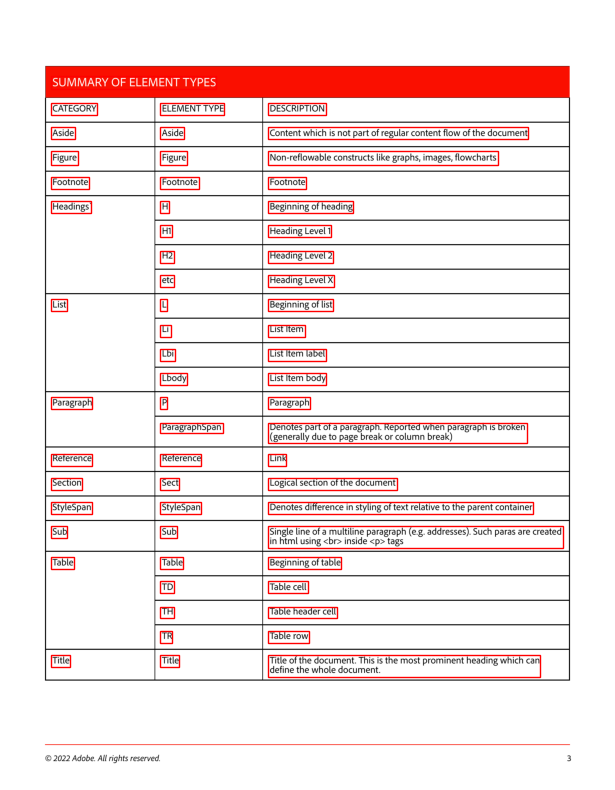

In [207]:
# Visualize detected bbox
pred_bbox = bbox_str_to_token_list(res_bbox[0])
pred_bbox = rescale_bbox(pred_bbox, src=(448, 448), tgt=images[0].size)

fig, ax = plt.subplots(figsize=(12, 10))
for i in pred_bbox:
    rect = patches.Rectangle(i[:2], i[2] - i[0], i[3] - i[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
ax.set_axis_off()
ax.imshow(images[0])

### Get cell content

In [208]:
res_cell = []

# Table cell content recognition
vocab, model = load_vocab_and_model(
    vocab_path="vocab/vocab_cell_6k.json",
    max_seq_len=200,
    model_weights=MODEL_DIR / MODEL_FILE_NAME[2],
)

for i_image in images:
    # Cell image cropping and transformation
    image_tensor = [image_to_tensor(i_image.crop(bbox), size=(112, 448)) for bbox in pred_bbox]
    image_tensor = torch.cat(image_tensor, dim=0)

    # Inference
    pred_cell = autoregressive_decode(
        model=model,
        image=image_tensor,
        prefix=[vocab.token_to_id("[cell]")],
        max_decode_len=200,
        eos_id=vocab.token_to_id("<eos>"),
        token_whitelist=None,
        token_blacklist = [vocab.token_to_id(i) for i in INVALID_CELL_TOKEN]
    )

    # Convert token id to token text
    pred_cell = pred_cell.detach().cpu().numpy()
    pred_cell = vocab.decode_batch(pred_cell, skip_special_tokens=False)
    pred_cell = [cell_str_to_token_list(i) for i in pred_cell]
    pred_cell = [re.sub(r'(\d).\s+(\d)', r'\1.\2', i) for i in pred_cell]

    # print(pred_cell)

    res_cell.append(pred_cell)

# Visualize the table

In [209]:
from bs4 import BeautifulSoup as bs


# Build html code based on html token and cell content
# Combine the table structure and cell content
def get_html_code(html, cell):
    html_code = build_table_from_html_and_cell(html.copy(), cell.copy())
    html_code = "".join(html_code)
    html_code = html_table_template(html_code)

    # beautify the html
    soup = bs(html_code)
    html_code = soup.prettify()

    return html_code

# Save HTML as EXCEL

In [210]:
import pandas as pd
from bs4 import BeautifulSoup
import openpyxl
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.worksheet.table import Table, TableStyleInfo


# Convert html into excel
# Can really merge cells
def html2excel(html_code, save_path):
    # Parse html tables
    soup = BeautifulSoup(html_code, 'html.parser')
    table = soup.find('table')
    
    # use pandas to read html
    df = pd.read_html(str(table))[0]

    # Create workbook and worksheet
    wb = Workbook()
    ws = wb.active

    # Write dataframe into worksheet
    for r_idx, row in enumerate(dataframe_to_rows(df, index=False, header=True), 1):
        for c_idx, value in enumerate(row, 1):
            ws.cell(row=r_idx, column=c_idx, value=value)

    # Deal with merged cells
    row_idx = 1
    for row in table.find_all('tr'):
        col_idx = 1
        for cell in row.find_all(['td', 'th']):
            rowspan = int(cell.get('rowspan', 1))
            colspan = int(cell.get('colspan', 1))
            
            if rowspan > 1 or colspan > 1:
                ws.merge_cells(start_row=row_idx, start_column=col_idx, 
                               end_row=row_idx + rowspan - 1, end_column=col_idx + colspan - 1)

            col_idx += colspan
        row_idx += 1

    # Save excel
    wb.save(save_path)
    print(f"Excel file saved successfully at {save_path}.")

In [212]:
for i_idx in range(len(res_html)):
    html_code = get_html_code(res_html[i_idx], res_cell[i_idx])
    html2excel(html_code=html_code, save_path=f"outputs/output-{i_idx}.xlsx")


Excel file saved successfully at outputs/output-0.xlsx.


## Evaluation - Proceed only if you have the groundtruth annotation.

In [ ]:
from src.utils.teds import TEDS
import jsonlines
from src.vocab.constant import CELL_SPECIAL

In [ ]:
# Load groundtruth annotation
annotation_path = "../dataset/mini_pubtabnet/mini_pubtabnet_examples.jsonl"
with jsonlines.open(annotation_path) as f:
    for obj in f:
        if obj["filename"] == image_name:
            anno_html_raw = obj["html"]["structure"]["tokens"]
            anno_cell_raw = ["".join(cell["tokens"]) for cell in obj["html"]["cells"] if cell["tokens"]]
            break

anno_html = []
idx = 0
while idx < len(anno_html_raw):
    if "[" in anno_html_raw[idx]:
        assert idx + 1 < len(anno_html_raw)
        assert anno_html_raw[idx + 1] == "]</td>"
        anno_html.append(anno_html_raw[idx] + "]</td>")
        idx = idx + 2
    else:
        anno_html.append(anno_html_raw[idx])
        idx = idx + 1

anno_cell = []
for txt in anno_cell_raw:
    for black in CELL_SPECIAL:
        txt = txt.replace(black, "")
    anno_cell.append(txt)

anno_code = "".join(build_table_from_html_and_cell(anno_html, anno_cell))

FileNotFoundError: [Errno 2] No such file or directory: '../dataset/mini_pubtabnet/mini_pubtabnet_examples.jsonl'

In [ ]:
# Evaluate table structure only (S-TEDS)
teds = TEDS(structure_only=True)
teds.evaluate(pred_code, html_table_template(anno_code))

1.0

In [ ]:
# Evaluate both table structure and cell content (TEDS)
teds = TEDS(structure_only=False)
teds.evaluate(pred_code, html_table_template(anno_code))

0.9523398767490218